In [ ]:
# #Setup Gdrive file download extention
!pip install gdown open-clip-torch faiss-gpu

In [ ]:
!gdown --id 1BFAJfzzeaUGsPoYELS86HIutJ43D-vat

In [ ]:
import os
import math

import numpy as np
 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import open_clip

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image
import time
import faiss
import copy
import argparse

In [ ]:
def compute_precision_at_k(ranked_targets: np.ndarray,
                           k: int) -> float:

    """
    Computes the precision at k.
    Args:
        ranked_targets: A boolean array of retrieved targets, True if relevant and False otherwise.
        k: The number of examples to consider

    Returns: The precision at k
    """
    assert k >= 1
    assert ranked_targets.size >= k, ValueError('Relevance score length < k')
    return np.mean(ranked_targets[:k])

def compute_average_precision(ranked_targets: np.ndarray,
                              gtp: int) -> float:
    
        
    """
    Computes the average precision.
    Args:
        ranked_targets: A boolean array of retrieved targets, True if relevant and False otherwise.
        gtp: ground truth positives.

    Returns:
        The average precision.
    """
    assert gtp >= 1
    # compute precision at rank only for positive targets
    out = [compute_precision_at_k(ranked_targets, k + 1) for k in range(ranked_targets.size) if ranked_targets[k]]
    if len(out) == 0:
        # no relevant targets in top1000 results
        return 0.0
    else:
        return np.sum(out) / gtp


def calculate_map(ranked_retrieval_results: np.ndarray,
                  query_labels: np.ndarray,
                  gallery_labels: np.ndarray) -> float:
    
    global current_retrievals, gpt
    
    """
    Calculates the mean average precision.
    Args:
        ranked_retrieval_results: A 2D array of ranked retrieval results (shape: n_queries x 1000), because we use
                                top1000 retrieval results.
        query_labels: A 1D array of query class labels (shape: n_queries).
        gallery_labels: A 1D array of gallery class labels (shape: n_gallery_items).
    Returns:
        The mean average precision.
    """
    assert ranked_retrieval_results.ndim == 2
    assert ranked_retrieval_results.shape[1] == 1000

    class_average_precisions = []
    current_retrievals = []

    class_ids, class_counts = np.unique(gallery_labels, return_counts=True)
    class_id2quantity_dict = dict(zip(class_ids, class_counts))
    for gallery_indices, query_class_id in tqdm(
                            zip(ranked_retrieval_results, query_labels),
                            total=len(query_labels)):
        # Checking that no image is repeated in the retrival results
        assert len(np.unique(gallery_indices)) == len(gallery_indices), \
                    ValueError('Repeated images in retrieval results')

        current_retrieval = gallery_labels[gallery_indices] == query_class_id
        gpt = class_id2quantity_dict[query_class_id]
        
        current_retrievals.append(current_retrieval)

        class_average_precisions.append(
            compute_average_precision(current_retrieval, gpt)
        )

    mean_average_precision = np.mean(class_average_precisions)
    return mean_average_precision

In [ ]:
import numpy as np
import time

def calculate_l2_distances(query, gallery):
    return np.linalg.norm(gallery - query, axis=1)

def get_k_nearest_neighbors(distances, k):
    indices = np.argsort(distances)[:k]
    return indices

def get_similiarity_l2(embeddings_gallery, embeddings_query, k):
    print('Processing indices...')

    s = time.time()

    scores = []
    indices = []

    for query in embeddings_query:
        distances = calculate_l2_distances(query, embeddings_gallery)
        nearest_indices = get_k_nearest_neighbors(distances, k)
        scores.append(distances[nearest_indices])
        indices.append(nearest_indices)

    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return np.array(scores), np.array(indices)

In [ ]:
def convert_indices_to_labels(indices, labels):
    indices_copy = copy.deepcopy(indices)
    for row in indices_copy:
        for j in range(len(row)):
            row[j] = labels[row[j]]
    return indices_copy

In [ ]:
device = 'cuda' if th.cuda.is_available() else 'cpu';

In [ ]:
# import numpy as np
# import time

# def calculate_l2_distances(query, gallery):
#     return np.linalg.norm(gallery - query, axis=1)

# def get_k_nearest_neighbors(distances, k):
#     indices = np.argsort(distances)[:k]
#     return indices

def get_similiarity_l2(embeddings_gallery, embeddings_query, k):
    print('Processing indices...')

    s = time.time()

    scores = []
    indices = []

    for query in embeddings_query:
        distances = calculate_l2_distances(query, embeddings_gallery)
        nearest_indices = get_k_nearest_neighbors(distances, k)
        scores.append(distances[nearest_indices])
        indices.append(nearest_indices)

    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return np.array(scores), np.array(indices)

def get_similiarity_hnsw(embeddings_gallery, emmbeddings_query, k):
    # this is guy is really fast
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexHNSWFlat(embeddings_gallery.shape[1], 32)
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k) 
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices

def get_similiarity_IP(embeddings_gallery, emmbeddings_query, k):
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexFlatIP(embeddings_gallery.shape[1])
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k) 
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices


def calculate_l2_distances(query, gallery):
    return np.linalg.norm(gallery - query, axis=1)

def calculate_cosine_similarities(query, gallery):
    query_norm = query / np.linalg.norm(query)
    gallery_norm = gallery / np.linalg.norm(gallery)
    return np.dot(gallery_norm, query_norm)

def calculate_correlation_distances(query, gallery):
    return 1 - np.corrcoef(query, gallery)[0, 1]


def get_similiarity_correlation(embeddings_gallery, embeddings_query, k):
    print('Processing indices...')

    s = time.time()

    scores = []
    indices = []

    for query in embeddings_query:
        distances = calculate_correlation_distances(query, embeddings_gallery)
        nearest_indices = np.argsort(distances)[:k]
        scores.append(distances[nearest_indices])
        indices.append(nearest_indices)

    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return np.array(scores), np.array(indices)

def get_similiarity_cosine(embeddings_gallery, embeddings_query, k):
    print('Processing indices...')

    s = time.time()

    scores = []
    indices = []

    for query in embeddings_query:
        distances = calculate_cosine_similarities(query, embeddings_gallery)
        nearest_indices = np.argsort(distances)[:k]
        scores.append(distances[nearest_indices])
        indices.append(nearest_indices)

    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return np.array(scores), np.array(indices)

# get_similiarity_l2
# get_similiarity_hnsw
# get_similiarity_IP
# get_similiarity_correlation
# get_similiarity_cosine

# Reading Dataset

In [ ]:
def read_image(image_file):
    img = cv2.imread(
        image_file, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise ValueError('Failed to read {}'.format(image_file))
    return img

class SubmissionDataset(Dataset):
    def __init__(self, root, annotation_file, transforms, with_bbox=False):
        self.root = root
        self.imlist = pd.read_csv(annotation_file)
        self.transforms = transforms
        self.with_bbox = with_bbox

    def __getitem__(self, index):
        cv2.setNumThreads(6)

        full_imname = os.path.join(self.root, self.imlist['img_path'][index])
        img = read_image(full_imname)

        if self.with_bbox:
            x, y, w, h = self.imlist.loc[index, 'bbox_x':'bbox_h']
            img = img[y:y+h, x:x+w, :]

        img = Image.fromarray(img)
        img = self.transforms(img)
        product_id = self.imlist['product_id'][index]
        return img, product_id

    def __len__(self):
        return len(self.imlist)

In [ ]:
def get_transform():  
    transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return transform

@th.no_grad()
def get_feature_vector(model, dataloader, use_cuda=True):
    features = []
    product_id = []
    
    for imgs, p_id in tqdm(dataloader):
        if use_cuda:
            imgs = imgs.cuda()
        features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
        product_id.append(th.squeeze(p_id).detach().cpu().numpy())

    return np.concatenate(features, axis=0), np.concatenate(product_id)

# Getting the CLIP model's embedding

In [ ]:
weights_path_large = '/kaggle/input/vit-l-14-final-weights/my_experiments/ViT-L-14-laion2b_s32b_b82k-image_net-v2-p10k-h&m-Arcface(k=3)-All-Epoch(4)-Reduce_LR_0.1/model_epoch_2_mAP3_0.52.pt'

vit_backbone_vit_l_14 = open_clip.create_model_and_transforms('ViT-L-14', None)[0].visual
vit_backbone_vit_l_14.load_state_dict(th.load(weights_path_large)['model_state_dict'])
vit_backbone_vit_l_14.half()   # Apply half precision to the backbone model
vit_backbone_vit_l_14.eval()   # Dropping unecessary layers
model_vit_l_14 = vit_backbone_vit_l_14
model_vit_l_14.cuda();

In [ ]:
weights_path_huge = '/kaggle/input/vit-h-14-final-weights/model_weights.pt'

vit_backbone_vit_h_14 = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
vit_backbone_vit_h_14.load_state_dict(th.load(weights_path_huge))
vit_backbone_vit_h_14.half()   # Apply half precision to the backbone model
vit_backbone_vit_h_14.eval()   # Dropping unecessary layers
model_vit_h_14 = vit_backbone_vit_h_14
model_vit_h_14.cuda();

In [ ]:
# weights_path_convnext_320_focal = '/kaggle/input/convnext-large-d-final-weights/my_experiments/convnext_large_d_320-laion2b_s29b_b131k_ft-image_net-v2-p10k-h&m-Arcface(k=3)-All-Epoch(2)-Reduce_LR_0.1/model_epoch_1_mAP3_0.55.pt'

# vit_backbone_convnext_320_focal = open_clip.create_model_and_transforms('convnext_large_d_320', None)[0].visual
# vit_backbone_convnext_320_focal.load_state_dict(th.load(weights_path_convnext_320_focal)['model_state_dict'])
# vit_backbone_convnext_320_focal.half()   # Apply half precision to the backbone model
# vit_backbone_convnext_320_focal.eval()   # Dropping unecessary layers
# model_convnext_320_focal = vit_backbone_convnext_320_focal
# model_convnext_320_focal.cuda();

In [ ]:
weights_path_convnext_focal = '/kaggle/input/convnext-large-d-final-weights/my_experiments/convnext_large_d-laion2b_s26b_b102k_augreg-image_net-v2-p10k-h&m-Arcface(k=3)-All-Epoch(4)-Reduce_LR_0.1/model_epoch_4_mAP3_0.52.pt'

vit_backbone_convnext_focal = open_clip.create_model_and_transforms('convnext_large_d', None)[0].visual
vit_backbone_convnext_focal.load_state_dict(th.load(weights_path_convnext_focal)['model_state_dict'])
vit_backbone_convnext_focal.half()   # Apply half precision to the backbone model
vit_backbone_convnext_focal.eval()   # Dropping unecessary layers
model_convnext_focal = vit_backbone_convnext_focal
model_convnext_focal.cuda();

In [14]:
# model = model_vit_l_14

In [16]:
th.save(model_vit_l_14.state_dict(), 'vit_l_14_0.520_224_ce.pt')

In [15]:
transform = get_transform()

img_dir = "/kaggle/input/vprtestdata/public_dataset/"

dataset_train = SubmissionDataset(img_dir, os.path.join(img_dir, "gallery.csv"), transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)
dataset_test = SubmissionDataset(img_dir, os.path.join(img_dir, "queries.csv"), transform, with_bbox=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
def predict(model):
    global feature_vectors_gallery, labels_gallery
    
    feature_vectors_gallery, labels_gallery = get_feature_vector(model, dataloader_train, 1)
    feature_vectors_query, labels_query = get_feature_vector(model, dataloader_test, 1)
    
    scores, indices = get_similiarity_l2(feature_vectors_gallery, feature_vectors_query, 1000)

    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    return indices

In [17]:
preds = predict(model)

preds_df = pd.DataFrame(preds)
preds_df.to_csv('preds.csv', index=False)

100%|██████████| 4/4 [01:35<00:00, 23.85s/it]


Processing indices...
Finished processing indices, took 3.0682764053344727s


In [18]:
preds_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,768,923,972,193,511,285,771,412,266,327,...,18,376,834,924,644,250,366,1030,481,428
1,607,508,458,1025,994,729,160,426,469,1042,...,650,162,810,403,878,668,903,315,428,612
2,494,205,734,1046,631,829,375,1041,986,1012,...,156,937,497,573,901,492,698,405,463,182
3,655,249,613,1027,722,778,824,139,280,429,...,511,1018,210,412,409,1066,514,422,497,173
4,997,589,294,1050,363,562,286,102,543,240,...,637,99,375,215,187,934,1046,996,1041,2


In [19]:
seller_gt = pd.read_csv('/kaggle/input/vprtestdata/public_dataset/gallery.csv')
gallery_labels = seller_gt['product_id'].values
user_gt = pd.read_csv('/kaggle/input/vprtestdata/public_dataset/queries.csv')
query_labels = user_gt['product_id'].values

# Evalaute metrics
print("Evaluation Results")
results = {"mAP": calculate_map(np.array(preds), query_labels, gallery_labels)}
print(results)

Evaluation Results


100%|██████████| 1935/1935 [00:00<00:00, 5876.69it/s]

{'mAP': 0.6076191768389487}


# sample image similarity search

In [20]:
len(current_retrievals)

1935

In [21]:
def transform_img(image):
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if isinstance(img, np.ndarray):
        img =  Image.fromarray(img)
        
    img = transform(img)

    return img

In [32]:
@th.no_grad()
def get_feature_vector_img(model, imgs, use_cuda=True):
    features = []
    if use_cuda:
        imgs = imgs.cuda()
    x = (model(imgs.half())).detach().cpu().numpy().astype(np.float32)  # .half()
    print(model(imgs.half()).shape)
    features.append(x)

    return np.concatenate(features, axis=0)

In [33]:
img_path = '/kaggle/input/vprtestdata/public_dataset/queries/accelerated-glorious-fennec-of-reward.jpg'

def get_similar_prods(img_path):

    image = read_image(img_path)
    image = transform_img(image)
    image = image.unsqueeze(dim=0)
#     feature_vectors_gallery, labels_gallery = get_feature_vector(model, dataloader_train, 1)
    feature_vectors_query = get_feature_vector_img(model, image, 1)
    scores, indices = get_similiarity_l2(feature_vectors_gallery, feature_vectors_query, 1000)
    preds = convert_indices_to_labels(indices, labels_gallery)
    indices = indices.tolist()

    return [indices , preds]
    
[similar_images, labels] = get_similar_prods(img_path)

torch.Size([1, 1024])
Processing indices...
Finished processing indices, took 0.0022499561309814453s


In [31]:
csv_path_q = '/kaggle/input/vprtestdata/public_dataset/queries.csv'  
data_q = pd.read_csv(csv_path_q)

x = data_q[data_q['img_path'] == 'queries/accelerated-glorious-fennec-of-reward.jpg']

x

,user_img_id,img_path,bbox_x,bbox_y,bbox_w,bbox_h,product_id
854,854,queries/accelerated-glorious-fennec-of-reward.jpg,5,67,460,602,26


In [25]:
preds_df1 = pd.DataFrame(similar_images)

preds_df1

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,124,528,175,293,452,948,946,631,481,1041,...,396,85,950,693,542,183,750,466,207,73


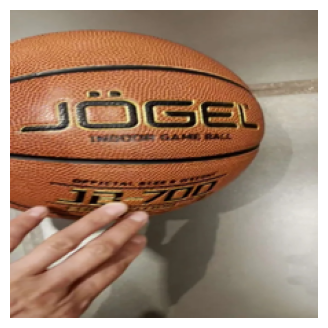

In [26]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)

img = img.resize((224, 224))

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.savefig('query.png')  
plt.show()

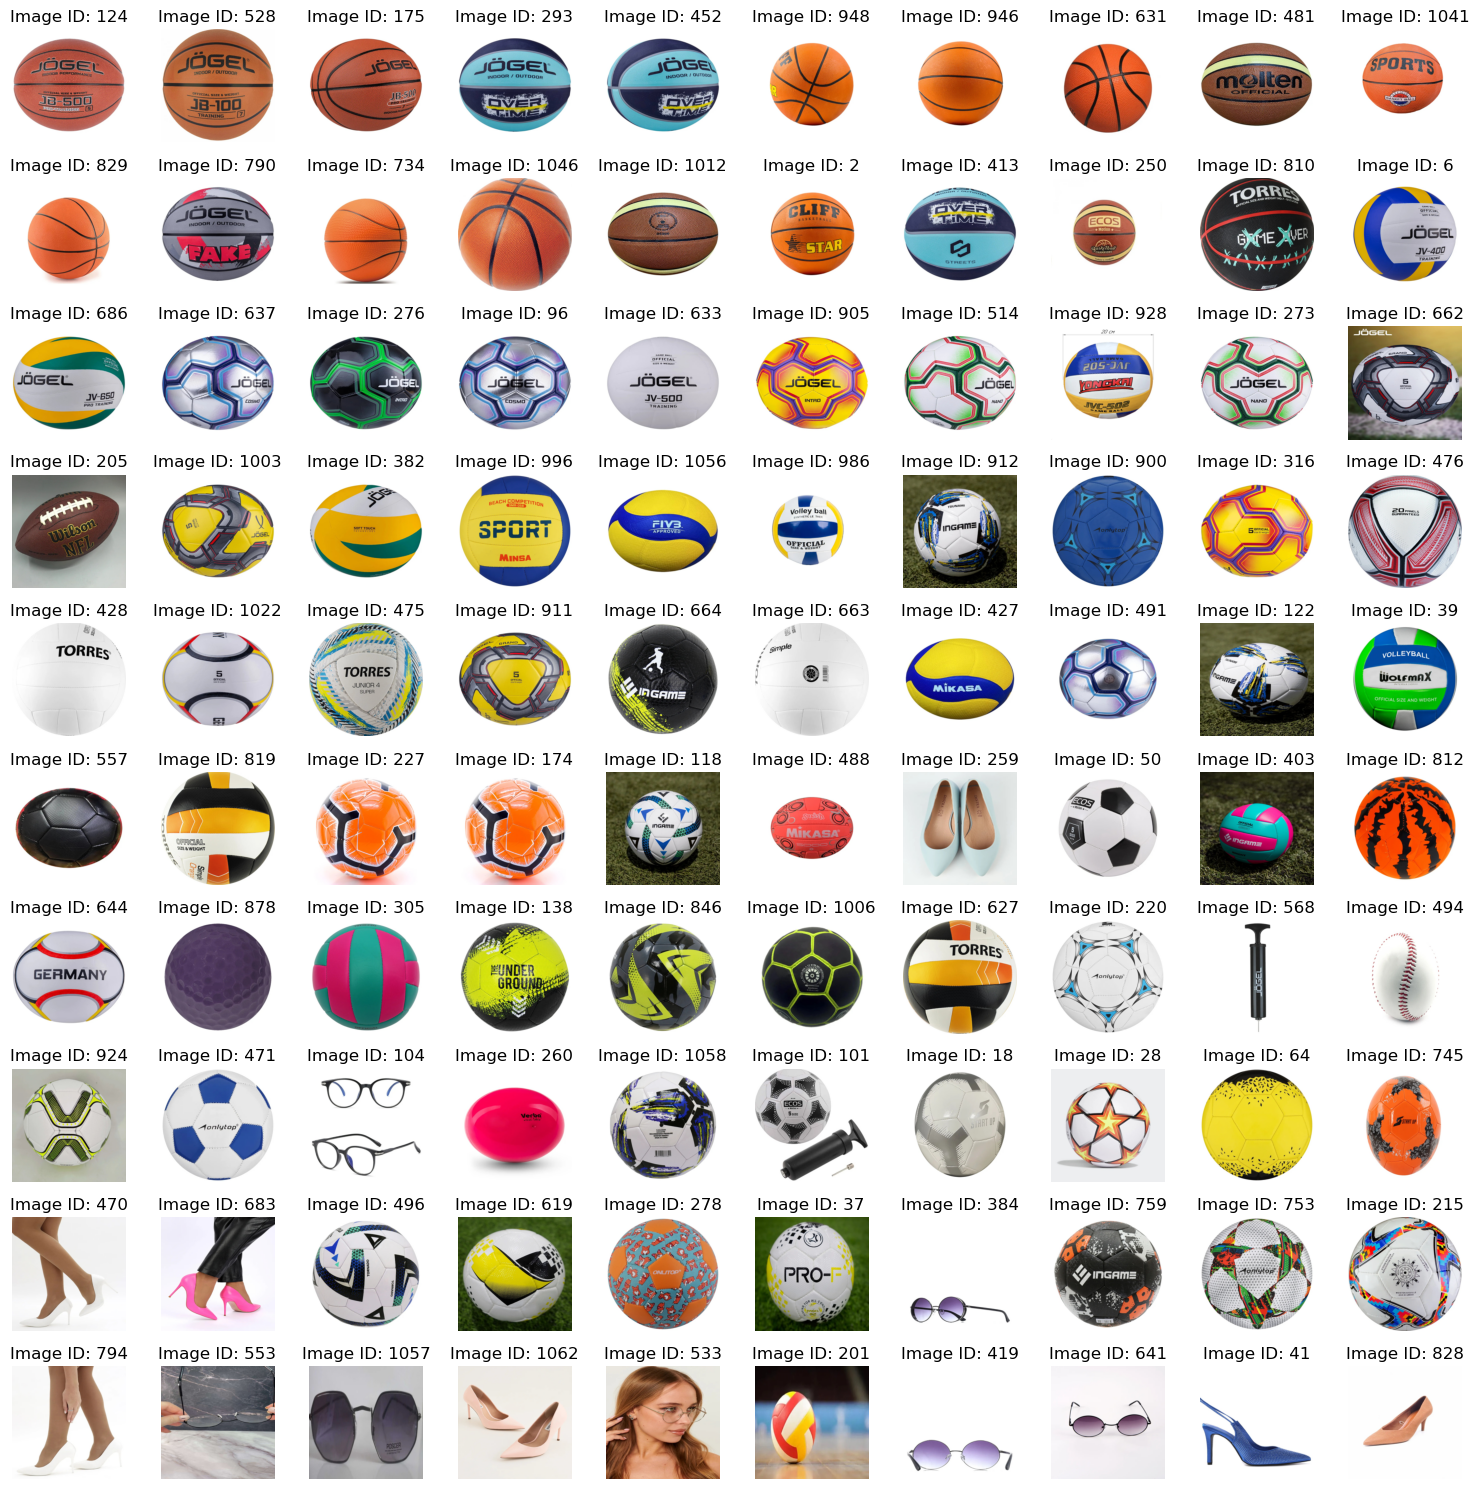

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

csv_path = '/kaggle/input/vprtestdata/public_dataset/gallery.csv'  
data = pd.read_csv(csv_path)

prod_ids = similar_images[0][:100]  

num_images = len(prod_ids)
num_columns = 10
num_rows = (num_images + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

for i, prod_id in enumerate(prod_ids):
    row = data[data['seller_img_id'] == prod_id]
    
    if not row.empty:
        image_path = '/kaggle/input/vprtestdata/public_dataset/' + row.iloc[0]['img_path']
        img = Image.open(image_path)
        
        img = img.resize((224, 224))
        
        row_idx = i // num_columns
        col_idx = i % num_columns
        
        ax = axes[row_idx, col_idx]
        ax.imshow(img)
        ax.set_title(f"Image ID: {prod_id}")
        ax.axis('off')

for i in range(num_images, num_rows * num_columns):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()

plt.savefig('inference.png')  

plt.show()


In [28]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

NameError: name 'data_path' is not defined